In [1]:
from fastai.basics import *
from fastai.vision.all import *
from fastai.vision.gan import *
from fastai.callback.all import *

from monai.networks.nets import UNet

from bioMONAI.data import *
from bioMONAI.transforms import *


/home/bm/miniforge3/envs/biomonai/lib/python3.11/site-packages/monai/utils/module.py:399: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module
Disabling PyTorch because PyTorch >= 2.1 is required but found 2.0.1
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
28-Jul-25 20:04:57 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


In [2]:
bs = 128
size = 64

In [3]:
def get_gt(path, gt_file_name="avg50.png"): 
    def _fn(fn): return Path(path/"gt")/f"{parent_label(fn)}"/gt_file_name
    return _fn

In [4]:
path = '../_data/Confocal_BPAE_B/raw'

data_ops = {
    'blocks':       (BioImageBlock(cls=BioImage), BioImageBlock(cls=BioImage)),              # define a `TransformBlock` tailored for bioimaging data
    'get_items':    get_image_files,                                                               # get image files in path
    'get_x':        get_gt(Path('../_data/Confocal_BPAE_B')),                                                                  # Label item with the parent folder name
    'get_y':        lambda x: x,                                                # Label item with the grandparent folder name
    'valid_pct':    0.05,                     # split data with the grandparent folder name
    'item_tfms':    [RandCrop2D(size)], # list of item transforms
    'batch_tfms':   Normalize.from_stats(torch.tensor([0.5,0.5,0.5]), torch.tensor([0.5,0.5,0.5])),
    'bs':           bs,                                                                    # batch size
}

data = BioDataLoaders.from_source(
    path,                           # root directory for data
    show_summary=False,             # print summary of the data
    **data_ops,                     # rest of method arguments
    )

# print length of training and validation datasets
print('train images:', len(data.train_ds.items), '\nvalidation images:', len(data.valid_ds.items))

train images: 800 
validation images: 200


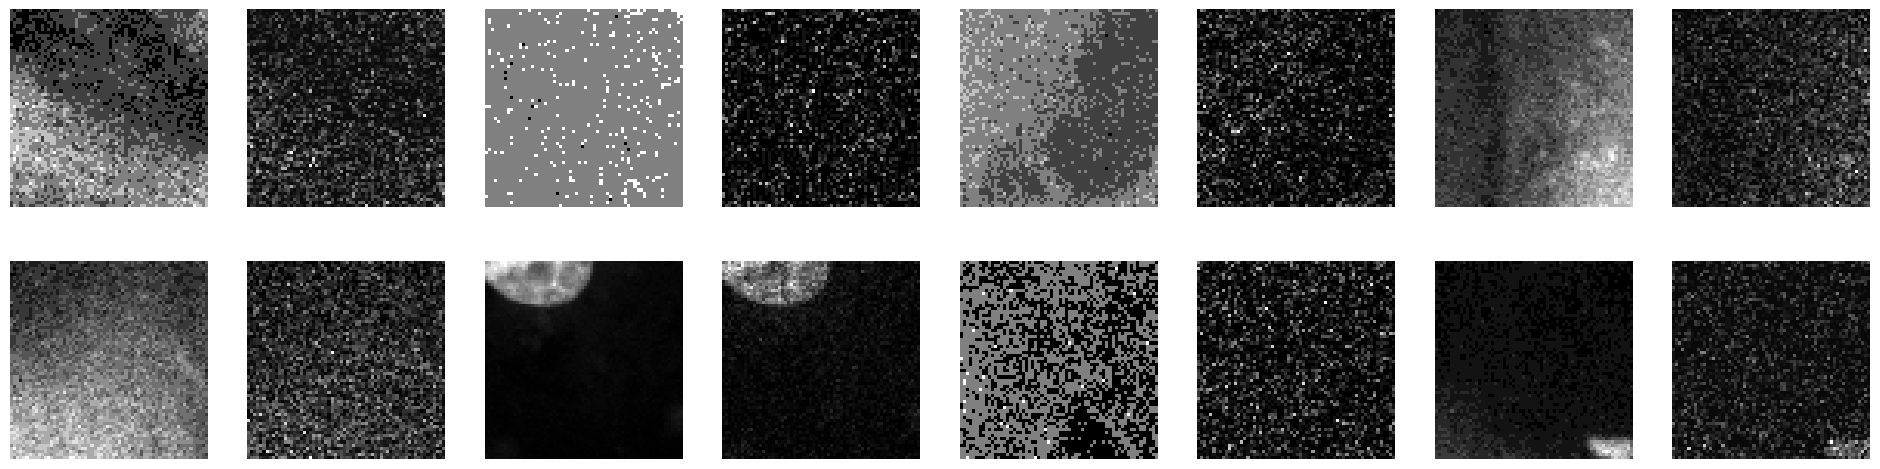

In [5]:
data.show_batch(max_n=8)

In [6]:
# generator = basic_generator(64, n_channels=1, n_extra_layers=1)
generator = UNet(2, 1, 1, channels=(4, 8, 16), strides=(2, 2),)


In [7]:
# critic    = basic_critic(64, n_channels=3, n_extra_layers=1, act_cls=partial(nn.LeakyReLU, negative_slope=0.2))
critic    = gan_critic(n_channels=1)


In [8]:
learn = GANLearner.wgan(data, generator, critic, opt_func = RMSProp)

learn.recorder.train_metrics=True
learn.recorder.valid_metrics=False

In [9]:
learn.fit_one_cycle(100, 1e-3, wd=0.)

/home/bm/miniforge3/envs/biomonai/lib/python3.11/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/bm/miniforge3/envs/biomonai/lib/python3.11/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/bm/miniforge3/envs/biomonai/lib/python3.11/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,gen_loss,crit_loss,time
0,-2555.725342,-8.855750,-3524.030029,00:05
1,-9171.391602,-44.314968,-15667.432617,00:05
2,-20479.978516,-245.935425,-44006.261719,00:05
3,-29629.142578,-499.743134,-58261.878906,00:05
4,-36985.750000,-641.925293,-70105.820312,00:05
5,-41806.429688,-745.183350,-70526.367188,00:05
6,-44930.250000,-562.076660,-67684.757812,00:05
7,-48039.218750,-867.235535,-74037.320312,00:05
8,-50323.011719,-1301.510132,-70982.398438,00:05
9,-51990.070312,-1011.221497,-72361.929688,00:05


/home/bm/miniforge3/envs/biomonai/lib/python3.11/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (generator) that exists in the learner. Use `self.learn.generator` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/bm/miniforge3/envs/biomonai/lib/python3.11/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (critic) that exists in the learner. Use `self.learn.critic` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")
/home/bm/miniforge3/envs/biomonai/lib/python3.11/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (gen_mode) that exists in the learner. Use `self.learn.gen_mode` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


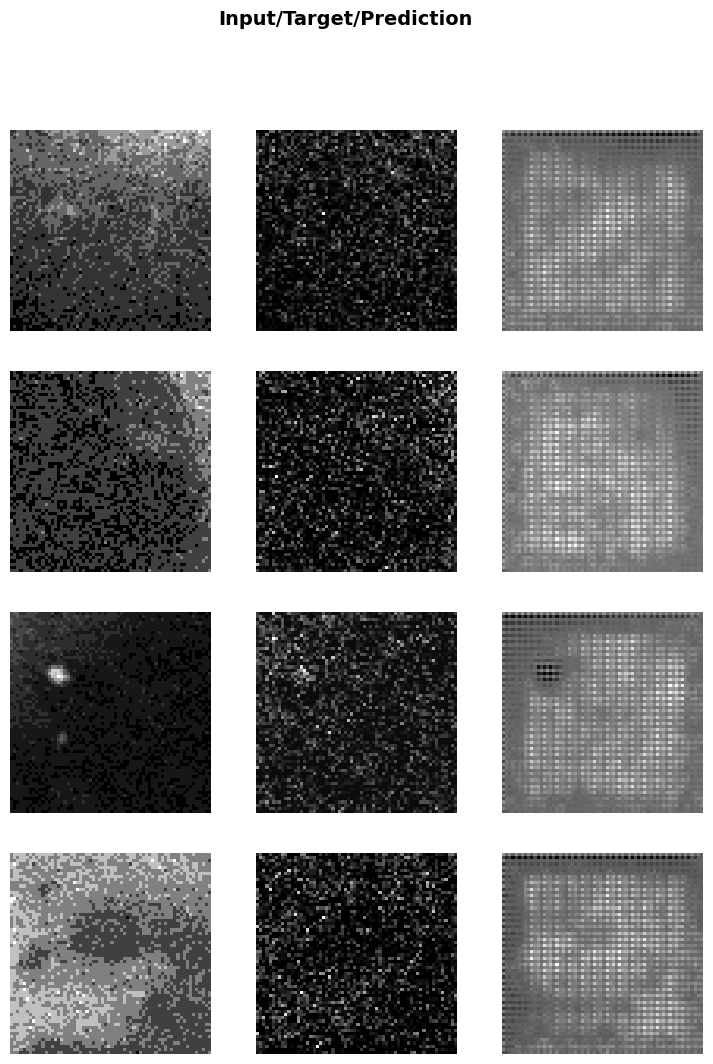

In [11]:
learn.show_results(max_n=4, ds_idx=0)